In [2]:
#RUN THE NIRS_DB_DOS_event_conversion-CARE.ipynb SCRIPT in the Beh notebook WHEN NEW SUBJECTS HAVE BEEN ADDED

#general dependencies (importing premade packages/libraries)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm

In [3]:
from platform import python_version
python_version()

'3.7.5'

In [4]:
import pycwt as wavelet
from pycwt.helpers import find

In [5]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.src import argParser
from LCBDtools.src import Plots

In [8]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset
debug = True

# set block durations (blocks here are actually trials) (original data has start and stop data points, those stop data points are eventually removed to replace with durations instead, they are easier to work with)
durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [9]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [10]:
# make a list of all matching session paths (in this case for V0, assuming there should be more sessions?)
session_dirs = [d for d in glob(study_dir+"/*/V0/*") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [11]:
session_dirs

['/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51241/V0/5124_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51241/V0/51241_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51701/V0/5170_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51701/V0/51701_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51331/V0/51331_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51331/V0/5133_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51491/V0/51491_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51491/V0/5149_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50841/V0/5084_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50841/V0/50841_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50021/V0/5002_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50021/V0/50021_V0_fNIRS',
 '/data/perlman/moochi

In [12]:
len(session_dirs)

317

In [13]:
len(session_dirs)/2

158.5

In [14]:
# make a list where all of the scans will get loaded into (for children and for parent)
scans = []

# loop over all the session directories (dyads / DB-DOS folders)
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        
        # get subject and visit from this path
        sub = os.path.basename(os.path.dirname(dyad_dir))
        visit = os.path.basename(dyad_dir)
        
        if debug:
            print(f'{sub} - {visit}')
        
        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*fNIRS", "*config*"))

        # open the file and read the line with Subject= in it
        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
                    
        # make sure it has 'modern' .evt files
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue

#         #**load each in via hypyp loader (fixing config file so that even if child and parent numbers were flipped, they will now each be labelled as c or p in object)**
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
    
    #when there aren't 2 evt files    
    except:
        print("skipping session:", dyad_dir)
        continue

50501 - V0
51781 - V0
51651 - V0
51521 - V0
50962 - V0
51331 - V0
50601 - V0
51381 - V0
51082 - V0


/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:43: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


51461 - V0
50831 - V0
50261 - V0
51471 - V0
50371 - V0
51141 - V0
51701 - V0
50001 - V0
50291 - V0
51181 - V0
51801 - V0
50992 - V0
50221 - V0
51041 - V0
50731 - V0
50451 - V0
51011 - V0
51441 - V0
51021 - V0
50961 - V0
51841 - V0
50991 - V0
51263 - V0
50281 - V0
51411 - V0
50503 - V0
50592 - V0
50701 - V0
50211 - V0
51431 - V0
51662 - V0
50841 - V0
50301 - V0
There should be 2 evt files. Skipping: 50301_V0_fNIRS
51691 - V0
50581 - V0
50422 - V0
50381 - V0
50751 - V0
There should be 2 evt files. Skipping: 50751_V0_fNIRS
50711 - V0
51741 - V0
51211 - V0


/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:43: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


50771 - V0
51091 - V0
50031 - V0
51131 - V0
51231 - V0
50331 - V0
51591 - V0
50111 - V0
50071 - V0
51491 - V0
51191 - V0
50591 - V0
51051 - V0
50391 - V0
51281 - V0
51731 - V0
51421 - V0
50091 - V0
50321 - V0


/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:43: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


51262 - V0
51271 - V0
50401 - V0
50552 - V0
51052 - V0


/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:43: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=Fals

51251 - V0
51081 - V0
50781 - V0
50491 - V0
50421 - V0
50481 - V0
51481 - V0
51212 - V0
51121 - V0
51161 - V0
51201 - V0
51221 - V0
50121 - V0
50752 - V0
51301 - V0
51341 - V0
50361 - V0
50322 - V0
50241 - V0
50721 - V0
51001 - V0
50611 - V0
51261 - V0
50032 - V0


/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child


50021 - V0
50761 - V0
50342 - V0
50971 - V0
50351 - V0
50911 - V0
50981 - V0
50891 - V0
51601 - V0
51702 - V0
50802 - V0
50832 - V0
50861 - V0
51391 - V0
50621 - V0
50531 - V0
50092 - V0
51511 - V0
50461 - V0
51791 - V0
50341 - V0
51711 - V0
50441 - V0
51382 - V0
51171 - V0
51571 - V0
50431 - V0
51631 - V0
50181 - V0
50631 - V0
50602 - V0
51361 - V0
50081 - V0
50191 - V0
51132 - V0
50521 - V0
50941 - V0
51661 - V0
50942 - V0
50231 - V0
50171 - V0
50851 - V0
50131 - V0
50532 - V0
51831 - V0
51422 - V0
50691 - V0
50502 - V0
51751 - V0


/tmp/ipykernel_43843/1718574802.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43843/1718574802.py:43: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


50811 - V0
50251 - V0
50801 - V0
51851 - V0
50871 - V0
51241 - V0
51371 - V0
50551 - V0
50921 - V0
51652 - V0
51501 - V0


In [15]:
#raw NIRS data for child and parent now loaded into "scans" object
scans

[(<RawNIRX | 50501_V0_fNIRS, 20 x 15354 (1965.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 5050_V0_fNIRS, 20 x 15354 (1965.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51781_V0_fNIRS, 20 x 15034 (1924.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 5178_V0_fNIRS, 20 x 15034 (1924.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51651_V0_fNIRS, 20 x 14958 (1914.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 5165_V0_fNIRS, 20 x 14958 (1914.5 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51521_V0_fNIRS, 20 x 14991 (1918.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 5152_V0_fNIRS, 20 x 14991 (1918.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 50962_V0_fNIRS, 20 x 15599 (1996.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 5096_V0_fNIRS, 20 x 15599 (1996.5 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51331_V0_fNIRS, 20 x 15262 (1953.4 s), ~31 kB, data not loaded>,
  <RawNIRX | 5133_V0_fNIRS, 20 x 15262 (1953.4 s), ~31 kB, data not loaded>),
 (<RawNIRX | 50601_V0_fNIRS, 20 x 13999 (1791.7 s), ~31 kB, data

In [16]:
len(scans)

156

In [17]:
X = scans[0][0].get_data()

In [18]:
scans[0][0].get_data()

array([[0.5501136, 0.556771 , 0.5605887, ..., 0.2158168, 0.2155689,
        0.2168874],
       [1.3284321, 1.3386095, 1.3516388, ..., 0.5829682, 0.5913886,
        0.5873466],
       [0.7190206, 0.7223227, 0.7250454, ..., 0.2198043, 0.2213788,
        0.2211838],
       ...,
       [0.8032469, 0.8085325, 0.8136439, ..., 1.140528 , 1.1414197,
        1.1396215],
       [0.1140138, 0.1150933, 0.1161584, ..., 0.3632928, 0.3638025,
        0.3606351],
       [0.1394837, 0.1411477, 0.1426566, ..., 0.378006 , 0.3786136,
        0.3731771]])

In [19]:
scans[0][0].get_data().shape

(20, 15354)

In [20]:
t = scans[0][0].times

In [21]:
scans[26][0].times

array([0.000000e+00, 1.280000e-01, 2.560000e-01, ..., 1.911040e+03,
       1.911168e+03, 1.911296e+03])

In [22]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

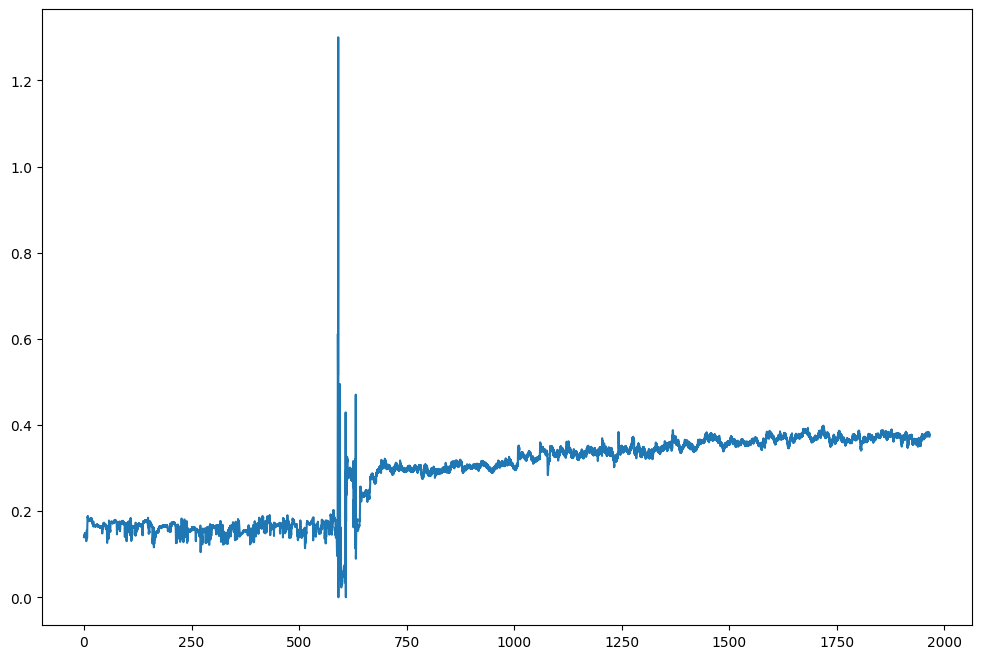

In [23]:
plt.plot(
    t,
    X[19]
)

In [24]:
#can use to check the subject info for each member of dyad in the scans object. First number selects dyad pair, 2nd number: 0 = child, 1 = parent
scans[0][0].info['subject_info']

{'his_id': '50501c',
 'first_name': '5050-1',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2021, 10, 24)}

In [25]:
#Checking annotation before running script to remove the stop annotations
scans[0][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [26]:
#if annotations don't match across subjects, need to check the evt files for consistency, run a event conversion script for the data
#Need to check if this works for the CARE data
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)


50501c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
51781c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
51651c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
51521c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
50962c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
51331c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
50601c <Annotations | 23 segments: 1.0 (4), 128.0 (11), 2.0 (4), 4.0 (4)>
51381c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
51082c <Annotations | 20 segments: 1.0 (4), 128.0 (10), 2.0 (4), 4.0 (2)>
51461c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
50831c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
50261c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
51471c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
50371c <Annotations | 24 segments: 1.0

In [27]:
# rename events and set durations for block 1 and 2

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any stop annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [28]:
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [29]:
scans[0][0].annotations.to_data_frame()

,onset,duration,description
0,2021-10-24 09:47:17.644,120.0,Block 1
1,2021-10-24 09:49:31.660,120.0,Block 1
2,2021-10-24 09:51:45.548,120.0,Block 1
3,2021-10-24 09:53:59.564,120.0,Block 1
4,2021-10-24 10:01:26.028,105.0,Block 2
5,2021-10-24 10:03:25.196,105.0,Block 2
6,2021-10-24 10:05:24.108,105.0,Block 2
7,2021-10-24 10:07:22.892,105.0,Block 2
8,2021-10-24 10:10:49.612,120.0,Block 3
9,2021-10-24 10:13:03.628,120.0,Block 3


In [30]:
len(scans)

155

In [31]:
scans

[(<RawNIRX | 50501_V0_fNIRS, 20 x 15354 (1965.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 5050_V0_fNIRS, 20 x 15354 (1965.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51781_V0_fNIRS, 20 x 15034 (1924.2 s), ~31 kB, data not loaded>,
  <RawNIRX | 5178_V0_fNIRS, 20 x 15034 (1924.2 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51651_V0_fNIRS, 20 x 14958 (1914.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 5165_V0_fNIRS, 20 x 14958 (1914.5 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51521_V0_fNIRS, 20 x 14991 (1918.7 s), ~31 kB, data not loaded>,
  <RawNIRX | 5152_V0_fNIRS, 20 x 14991 (1918.7 s), ~31 kB, data not loaded>),
 (<RawNIRX | 50962_V0_fNIRS, 20 x 15599 (1996.5 s), ~31 kB, data not loaded>,
  <RawNIRX | 5096_V0_fNIRS, 20 x 15599 (1996.5 s), ~31 kB, data not loaded>),
 (<RawNIRX | 51331_V0_fNIRS, 20 x 15262 (1953.4 s), ~31 kB, data not loaded>,
  <RawNIRX | 5133_V0_fNIRS, 20 x 15262 (1953.4 s), ~31 kB, data not loaded>),
 (<RawNIRX | 50601_V0_fNIRS, 20 x 13999 (1791.7 s), ~31 kB, data

In [32]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
#Sig1: raw MNE converted signal or Epoch; plot = set whether you want to plot the wavelet (True or False); chs: produce a wavelet for a specific channel
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    #Fourier Transform "transforms" data from time to frequency domain (certain number of oscillations per second)
    #The the final wavelet transform is an intermediate between time and frequency domain, it just needs to be transformed to frquency first
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
    #t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? (By default uses a Morlet convolution function to align detected signal with
    # with this base function) 
    #Video on Morlet wavelets
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    #reshaping of signal
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation (to remove drift effects)
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        #This is the actual function where dat_norm, dt etc. are entered to produce the wavelet tranformed matrix, weighted scales for each matrix, list of frequencies
        # coming from each matrix, the cone of influence (gives a prospective range in which signal should closely convolve with Morlet),
        #fast fourier transform? (fft)
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        # plotting the fourier tranform
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test (the degree of convergence of the signal and the Morlet function? Also compare frequencies in one epoch vs the other?)
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [33]:
#will be converted to HbO and HbR channels later in the script
scans[8][1].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

Using matplotlib as 2D backend.


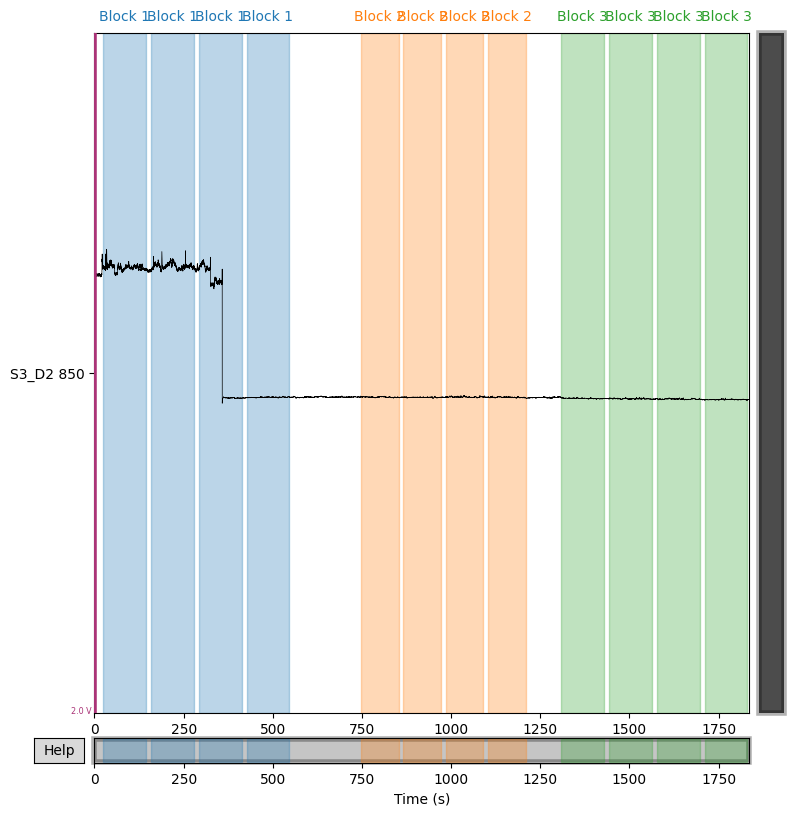

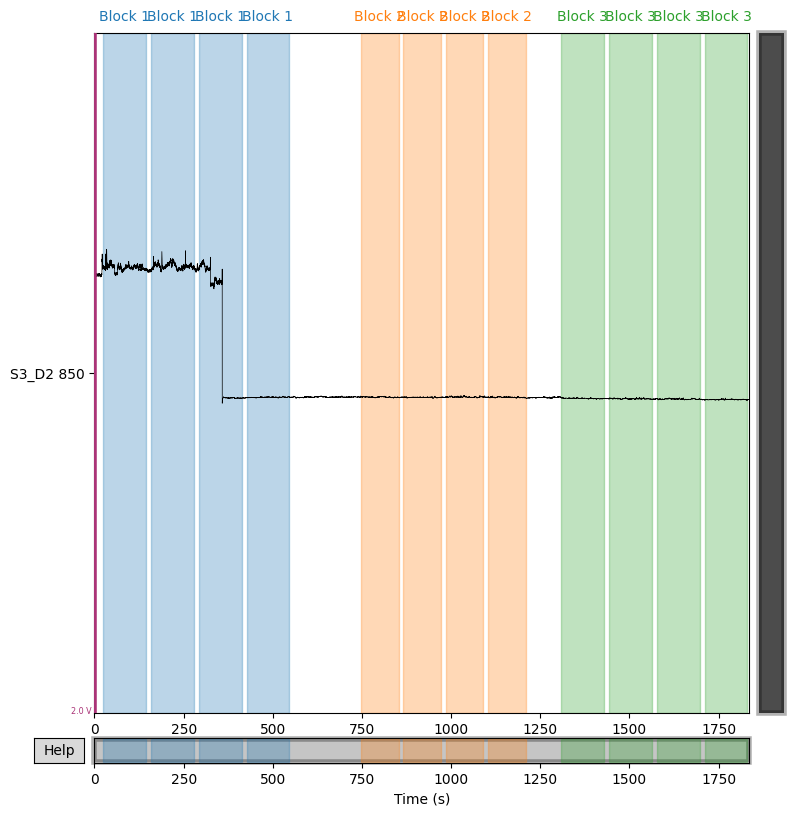

In [34]:
# example Block plot for 3000 seconds
scans[10][0].copy().pick(['S3_D2 850']).plot(duration=3000, scalings=1)

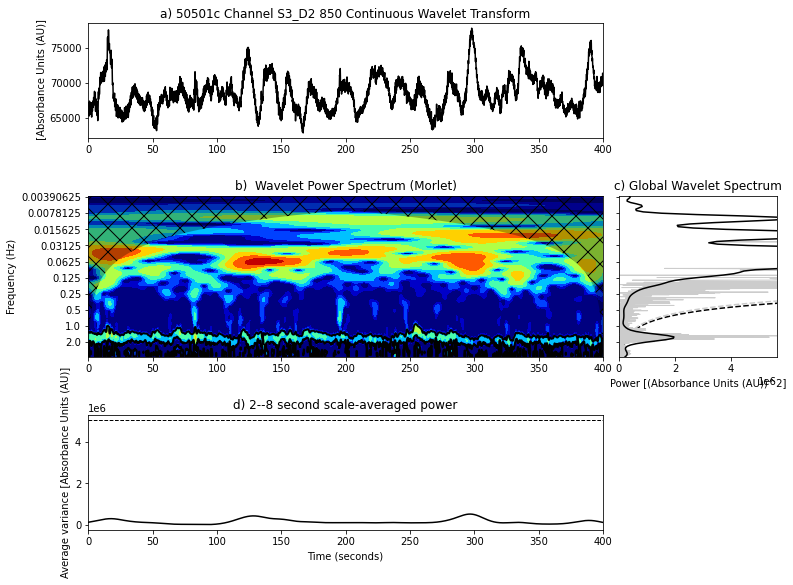

In [35]:
#Concise description of wavelet transform, inputs and outputs that were coded in the function above
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    #scans is object we built above that contains raw NIRS data from children and parent, first index number (0)
    #is the dyadic pair (can switch to any number of dyadic pairs in data, 2nd index is where you select child (0) or parent (1)
    scans[0][0].copy().crop(tmax=400),
    #to plot the data, would say False if you want no plot
    plot=True,
    #select the channel(s) you want to visualize data from
    chs=['S3_D2 850'])

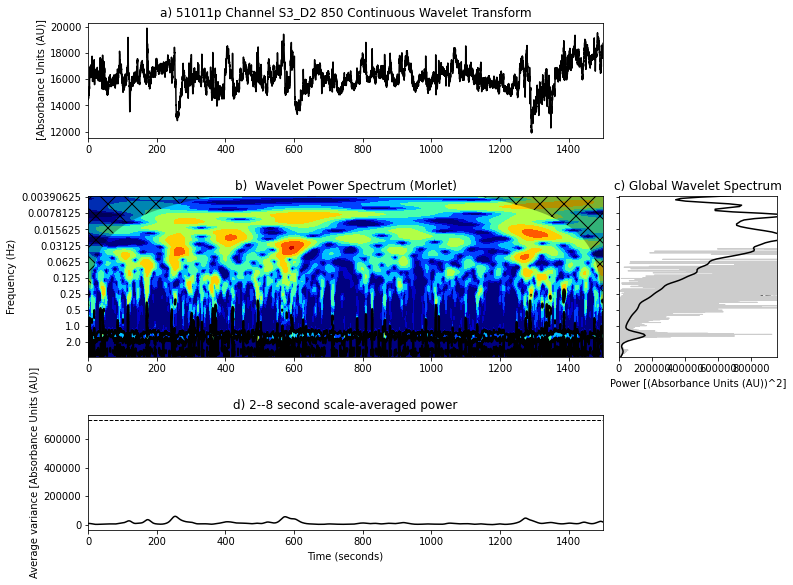

In [36]:
#Concise description of wavelet transform, inputs and outputs that were coded in the function above (clean)
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[25][1].copy().crop(tmax=1500),
    plot=True,
    chs=['S3_D2 850'])

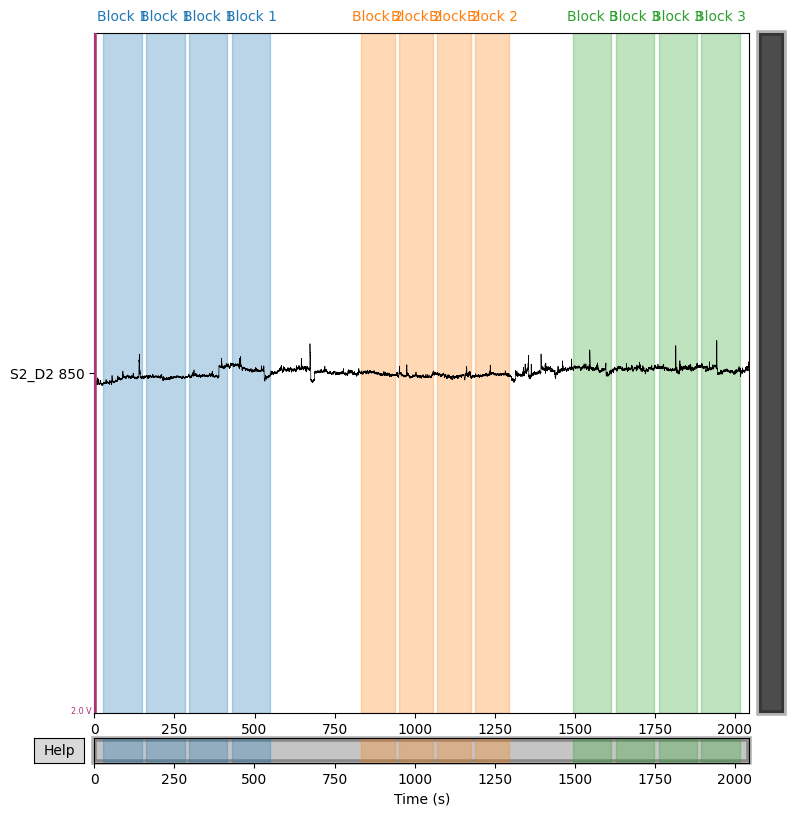

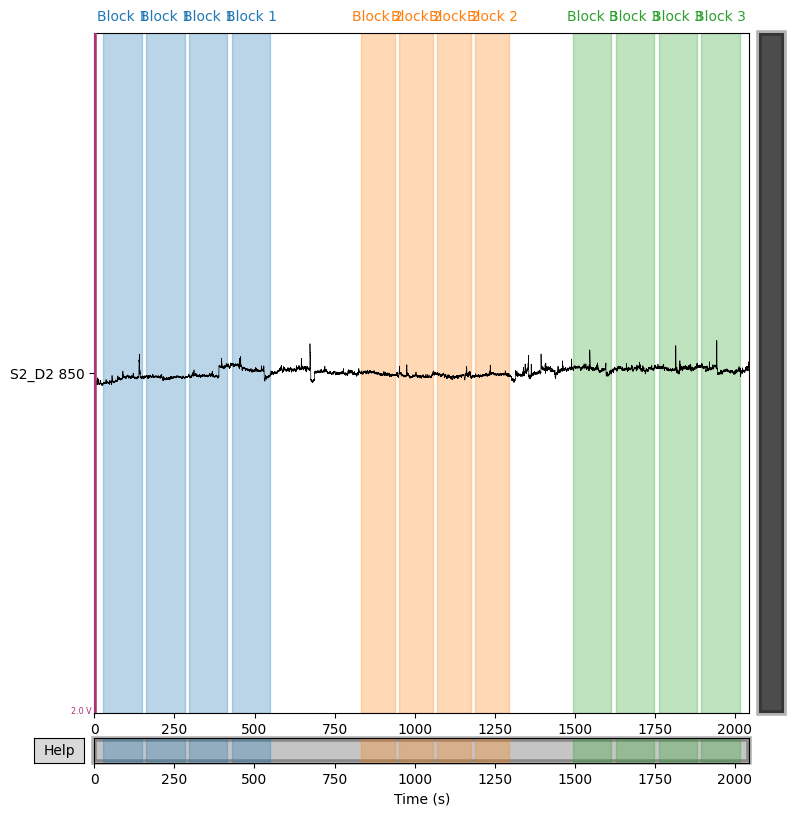

In [40]:
# example plot for 2200 seconds
scans[50][1].copy().pick(['S2_D2 850']).plot(duration=2200, scalings=1)

In [41]:
# example wavelet transform for 1800 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[6][1].copy().crop(tmax=1800),
    plot=True,
    chs=['S5_D3 850']
)

ValueError: tmax (1800) must be less than or equal to the max time (1791.7440 sec)

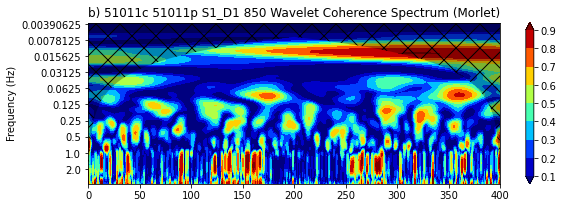

In [42]:
# example coherence transformo from a real dyad with 400 seconds (approach 1)
# 0 = child and 1 = parent for the 2nd index point of the scan object
#synchrony value goes from 0 to 1, 1 to max syncrhony
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[25][0].copy().crop(tmax=400),
    scans[25][1].copy().crop(tmax=400),
    plot=True,
    chs=['S1_D1 850'])

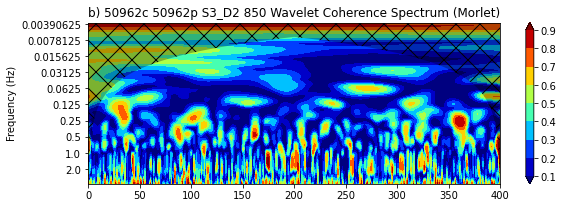

In [43]:
# example coherence transformo from a real dyad with 400 seconds (approach 2)
# 0 = child and 1 = parent for the 2nd index point of the scan object
#synchrony value goes from 0 to 1, 1 to max syncrhony
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[4][0].copy().pick(['S3_D2 850']).crop(tmax=400),
    scans[4][1].copy().pick(['S3_D2 850']).crop(tmax=400),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [44]:
#Here the signals collected from the various channels are converted to relaative hemoglobin concentration instead of a frequency waveform,
#which is what we were working with above before preprocessing

# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion using Beer Lambert Law (this will change channel names from frequency to hemo or deoxy hemo labelling)
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Bad channels in subject 51781c : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51381c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51381p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 50261p : ['S1_D1 760', 'S1_D1 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50371p : ['S1_D1 760', 'S1_D1 850', 'S3_D2 760', 'S3_D2 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51141c : ['S2_D1 760', 'S2_D1 850']
Bad channels in subject 51701p : ['S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850']
Bad channels in subject 50001p : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51181c : ['S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850']
Bad channels in subject 51181p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51801c : ['S6_D3 760', 'S6_D3 850']
Bad channels in subject 50992c : ['S2_D2 760', 'S2_D2 850']
Bad channels in subject 50221p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51041c : ['S1_

/tmp/ipykernel_43843/1016720289.py:16: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 51391c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 50531p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51791c : ['S6_D3 760', 'S6_D3 850']
Bad channels in subject 51791p : ['S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850']
Bad channels in subject 50341c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 50341p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51382c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51382p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51171p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51631p : ['S6_D3 760', 'S6_D3 850']
Bad channels in subject 51361c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 50081c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 50942p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 50231p : ['S7_D3 760', 'S7_D3 850']
Bad channels in subject 50131c : ['S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S7_D4 760', 'S7_D4 85

/tmp/ipykernel_43843/1016720289.py:16: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)
/tmp/ipykernel_43843/1016720289.py:16: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 51831p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850']
Bad channels in subject 51422c : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Bad channels in subject 51422p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50691c : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 50801p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51851c : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51851p : ['S7_D3 760', 'S7_D3 850']
Bad channels in subject 51371c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51371p : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 50921p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51501p : ['S1_D1 760', 'S1_D1 850']


In [45]:
#Creating a dictionary variable to store bad channels for later
bad_channels_dict = {}

for dscan in pps:
    
    for scan in dscan:
        
        bads = scan.info['bads']
        bad_channels_dict[scan.info['subject_info']['his_id']] = \
            bads

In [46]:
#Count of number of bad channels to report in any future manuscript (total channels overall is "Number of subjects x 20")
len(bad_channels_dict)

310

In [47]:
bad_channels_dict

{'50501c': [],
 '50501p': [],
 '51781c': ['S8_D4 hbo', 'S8_D4 hbr'],
 '51781p': [],
 '51651c': [],
 '51651p': [],
 '51521c': [],
 '51521p': [],
 '50962c': [],
 '50962p': [],
 '51331c': [],
 '51331p': [],
 '50601c': [],
 '50601p': [],
 '51381c': ['S5_D3 hbo', 'S5_D3 hbr'],
 '51381p': ['S8_D4 hbo', 'S8_D4 hbr'],
 '51082c': [],
 '51082p': [],
 '51461c': [],
 '51461p': [],
 '50831c': [],
 '50831p': [],
 '50261c': [],
 '50261p': ['S1_D1 hbo',
  'S1_D1 hbr',
  'S7_D4 hbo',
  'S7_D4 hbr',
  'S8_D4 hbo',
  'S8_D4 hbr'],
 '51471c': [],
 '51471p': [],
 '50371c': [],
 '50371p': ['S1_D1 hbo',
  'S1_D1 hbr',
  'S3_D2 hbo',
  'S3_D2 hbr',
  'S8_D4 hbo',
  'S8_D4 hbr'],
 '51141c': ['S2_D1 hbo', 'S2_D1 hbr'],
 '51141p': [],
 '51701c': [],
 '51701p': ['S2_D1 hbo',
  'S2_D1 hbr',
  'S2_D2 hbo',
  'S2_D2 hbr',
  'S3_D2 hbo',
  'S3_D2 hbr'],
 '50001c': [],
 '50001p': ['S5_D3 hbo', 'S5_D3 hbr'],
 '50291c': [],
 '50291p': [],
 '51181c': ['S5_D3 hbo', 'S5_D3 hbr', 'S6_D3 hbo', 'S6_D3 hbr'],
 '51181p': ['S1_D

In [48]:
bad_channels_dict['50001c']

[]

In [49]:
pps[7][0].info['subject_info']

{'his_id': '51381c',
 'first_name': '51381',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2022, 8, 1)}

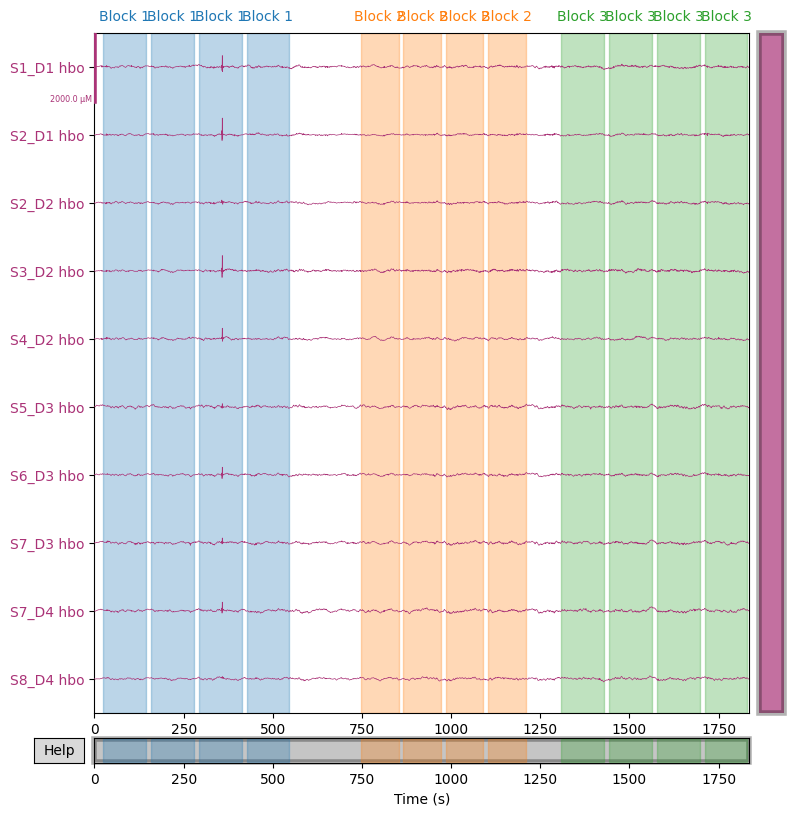

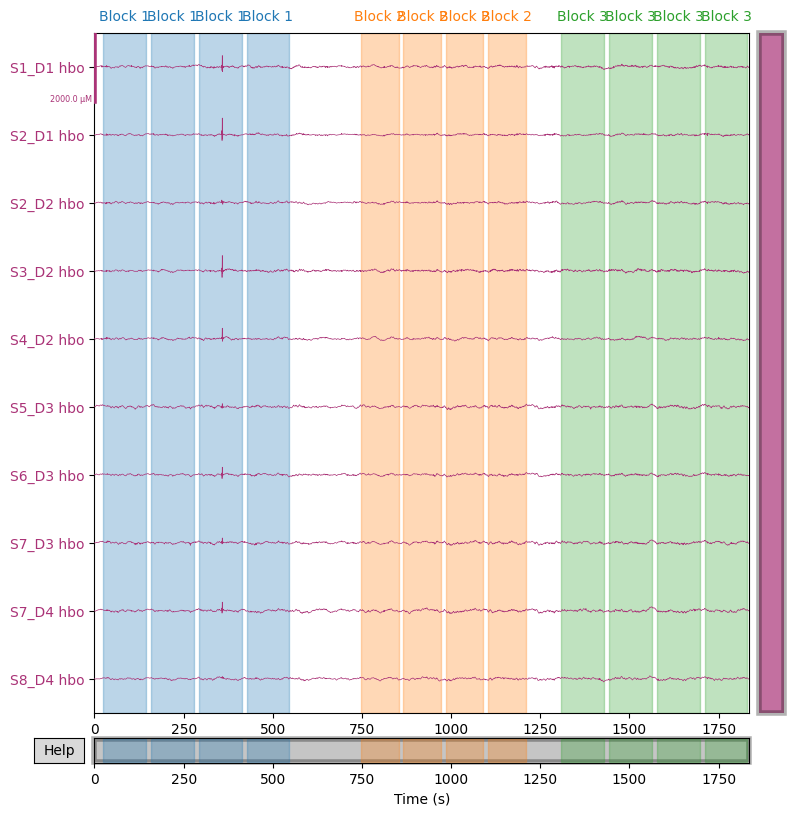

In [50]:
# example plot for 2200 seconds
#can either plot all hbo channels or a single channel for a subject
pps[10][0].copy().pick(['hbo']).plot(duration=2000, scalings=0.001)

In [51]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [52]:
pps[152][0]

<RawNIRX | 50921_V0_fNIRS, 20 x 14855 (1901.3 s), ~2.3 MB, data loaded>

In [56]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

In [55]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # February 9th 2023
    # Clayton update to prune subjects who have
    # >= 10 channels dropped from the SCI function during preprocessing
    max_bad = max([len(scan.info['bads']) for scan in dscan])
    # whichever number is higher ^, num. of channels dropped in
    # either parent or child
    
    if max_bad >= 10:
        for scan in dscan:
            sub_num = scan.info['subject_info']['his_id']
            print("Subject {} was dropped from further analysis.".format(sub_num))
        
        continue # skip this dyad
        # if max_bad is greater than or equal to 10
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#        for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline= (None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline= (None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

Subject 50701c was dropped from further analysis.
Subject 50701p was dropped from further analysis.
Subject 50211c was dropped from further analysis.
Subject 50211p was dropped from further analysis.
Subject 51431c was dropped from further analysis.
Subject 51431p was dropped from further analysis.
Subject 51741c was dropped from further analysis.
Subject 51741p was dropped from further analysis.
Subject 51421c was dropped from further analysis.
Subject 51421p was dropped from further analysis.
Subject 50091c was dropped from further analysis.
Subject 50091p was dropped from further analysis.
Subject 51422c was dropped from further analysis.
Subject 51422p was dropped from further analysis.


In [114]:
# here is the way to access information in the epoch dictionary

In [57]:
#Will tell you how many dyads are retaining for further analyses (not sure if we need this for the current CARE script)
len([sub for sub in epoch_df.keys() if "c" in sub])

148

In [58]:
# a single subject 
epoch_df['51331c']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 se

In [59]:
# a specific channel from the subject
epoch_df['50531c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [60]:
# a specific block at that subject / channel, in this case the first (0) is pre-play, second (1) is puzzle, and second (2) is post-play
#ask Susan about baseline 
epoch_df['50531c']['S1_D1 hbo'][2]

Number of events,4
Events,Block 3: 4
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [61]:
# a specific iteration (trial) of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
#120 sec duration of individual trial/iteration
epoch_df['50001c']['S1_D1 hbo'][0][3]

Number of events,1
Events,Block 1: 1
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [62]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

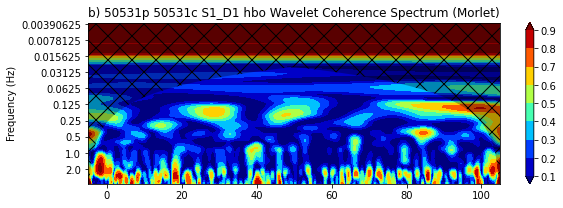

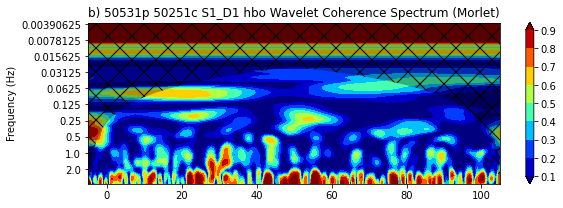

In [63]:
# example WCT between a real dyad, puzzle block (1), iteration 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['50531p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['50531c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['50531p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['50251c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

In [64]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['50501c', '50501p', '51781c', '51781p', '51651c', '51651p', '51521c', '51521p', '50962c', '50962p', '51331c', '51331p', '50601c', '50601p', '51381c', '51381p', '51082c', '51082p', '51461c', '51461p', '50831c', '50831p', '50261c', '50261p', '51471c', '51471p', '50371c', '50371p', '51141c', '51141p', '51701c', '51701p', '50001c', '50001p', '50291c', '50291p', '51181c', '51181p', '51801c', '51801p', '50992c', '50992p', '50221c', '50221p', '51041c', '51041p', '50731c', '50731p', '50451c', '50451p', '51011c', '51011p', '51441c', '51441p', '51021c', '51021p', '50961c', '50961p', '51841c', '51841p', '50991c', '50991p', '51263c', '51263p', '50281c', '50281p', '51411c', '51411p', '50503c', '50503p', '50592c', '50592p', '51662c', '51662p', '50841c', '50841p', '51691c', '51691p', '50581c', '50581p', '50422c', '50422p', '50381c', '50381p', '50711c', '50711p', '51211c', '51211p', '50771c', '50771p', '51091c', '51091p', '50031c', '50031p', '51131c', '51131p', '51231c', '51231p', '50331c',

In [65]:
# delete things we don't need anymore to save memory
del scans
del pps

In [66]:
import random

In [ ]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']
block_names = ['Pre-Play', 'Puzzle', 'Post-Puzzle']
trials = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4']
perm_df = {}

# THIS TAKES A REALLY LONG TIME TO COMPUTE. AROUND 14 HOURS ON A DECENT NETWORK
# SKIP DOWN TO USE THE SAVED VERSIONS!

#real vs single false dyad test of a myriad of real and fake dyad pairs

# for every parent subject
for parent in tqdm([sub for sub in sorted(epoch_df.keys()) if "p" in sub]):
    sync_df[parent] = {}
    perm_df[parent] = []
    
    # pick two children, one real and one random
    children = []
    
#     children.append(parent.replace("p", "c")) # real child
    
    # random sample of N children
    # could be repeated, could be the real dyad 
    randoms = random.choices(
        [sub for sub in epoch_df.keys() if "c" in sub],
        k=999) # N of random 
    # randoms = list(randoms).insert(0, parent.replace("p", "c"))
    perm_df[parent] = list(randoms)
    
    # only going to do synchrony once per kid
    # we can count # of repeats from perm_df[parent]
    for child in list(set(randoms)):
        children.append(child)
    
    # old version that just does 1 random non-real child per parent
#     children.append(
#         random.choice([sub for sub in epoch_df.keys() if "c" in sub \
#             and parent.replace("p", "") not in sub])) # random pick
    
    # loop over these 2 selected children (1 real, N random)
    for child in children:
        
        # and make them a location in the sync dictionary under this parent
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            # make this parent/child combo a location for this block type, also a dictionary
            sync_df[parent][child][block] = {}
                
            # for each channel available with this subject (not dropped)
            for ch in epoch_df[parent].keys():

                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over the 4 block iterations

                # so start keeping track of values to average now
                pc_wcts = []

                # load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()

                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):

                    # try to do the WCT with these epochs
                    try:
                        sync_df[parent][child][block][f'Trial {block_it + 1}'] = {}
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False, # save plots but only for some random channel because otherwise it's an insane amount
                            fig_fname=f"/data/perlman/moochie/analysis/eDOC_NARSAD/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest

                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED here
                        WCT[(2>(1/freqs))|((1/freqs)>13), :] = np.nan

                        # between periods of 2s and 13s (.08 -.5 Hz; flip for sec) which is based on Reindl et al 2018 paper (in Reindl study a single trial typcially took 5-8 sec)
                        #also in Reindl paper, significant coherence values were identifed above .65 (can be between 0 and 1)


                        # average inside cone of influence
                        # and within values from freq range determined above
                        sync_df[parent][child][block][f'Trial {block_it + 1}'][ch] = np.nanmean(nanWCT)
                    # if anything with the WCT fails, say so
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  
                

  3%|▉                                   | 4/148 [1:26:12<51:44:43, 1293.63s/it]

In [ ]:
sync_df

In [710]:
# del sync_df['51391p']

In [67]:
list(sync_df['50861p']['50861c']['Block 1']['Trial 1'].values())

[0.2575046347183404,
 0.268589722137367,
 0.2488316996514053,
 0.26258190975576384,
 0.2366100255867215,
 0.2777836239347354,
 0.24503653180612284,
 0.21384750685228418,
 0.24571166617825915,
 0.21856564299673278]

In [92]:
#important to set channels here
channels = epoch_df[parent].keys()

In [93]:
channels

dict_keys(['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D2 hbo', 'S4_D2 hbo', 'S5_D3 hbo', 'S6_D3 hbo', 'S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo'])

In [94]:
epoch_df['51382p']

{'S1_D1 hbo': [<Epochs |  1 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   '8.0': 1>,
  <Epochs |  3 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 3>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>],
 'S2_D1 hbo': [<Epochs |  1 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   '8.0': 1>,
  <Epochs |  3 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 3>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>],
 'S2_D2 hbo': [<Epochs |  1 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   '8.0': 1>,
  <Epochs |  3 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, d

In [1130]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING (Stats test are being ran concerning study hypotheses, use a different notebook)

In [433]:
# skip if you're going to load the already-saved ones. for real. don't overwrite this with an empty data file. 
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/CARE/Test_Analysis/trail_wct_full_permuted_values.json", 'w') as outfile:
    json.dump(sync_df, outfile)
    
    
# also save as CSV
import pandas as pd

cols = ["Parent", "Child", "Block"]
for ch in channels:
    cols.append(ch)
    
df = pd.DataFrame(columns=cols)    

for parent in sync_df.keys():
    
    for child in sync_df[parent].keys():
        
        for block in sync_df[parent][child].keys():
            
            dic = {
                'Parent': parent,
                'Child': child,
                'Block': block}
            
            for key, val in sync_df[parent][child][block].items():
                dic[key] = val
            
#             print(dic)
            df = df.append(dic, ignore_index=True)
        
print(df)
df.to_csv("/data/perlman/moochie/analysis/CARE/Test_Analysis/trial_wct_full_permuted_values.csv")

       Parent   Child    Block  S1_D1 hbo  S2_D1 hbo  S2_D2 hbo  S3_D2 hbo  \
0      50001p  50291c  Block 1   0.251709   0.251525   0.299057   0.261383   
1      50001p  50291c  Block 2   0.289868   0.268776   0.244401   0.292095   
2      50001p  50291c  Block 3   0.239715   0.246823   0.288193   0.260592   
3      50001p  51181c  Block 1   0.300608   0.263878   0.241687   0.234232   
4      50001p  51181c  Block 2   0.243152   0.234133   0.251255   0.247847   
...       ...     ...      ...        ...        ...        ...        ...   
67405  51851p  50771c  Block 2   0.266846   0.225000   0.251856   0.273402   
67406  51851p  50771c  Block 3   0.242324   0.239497   0.233044   0.252672   
67407  51851p  51201c  Block 1   0.264559   0.245492   0.242274   0.224489   
67408  51851p  51201c  Block 2   0.262602   0.246049   0.244352   0.277305   
67409  51851p  51201c  Block 3   0.240144   0.258437   0.252288   0.222593   

       S4_D2 hbo  S5_D3 hbo  S6_D3 hbo  S7_D3 hbo  S7_D4 hbo  S

In [434]:
# Save permuted values

json_object = json.dumps(perm_df, indent=4)
with open("/data/perlman/moochie/analysis/CARE/Test_Analysis/trial_permuted_subjects.json", 'w') as outfile:
    json.dump(perm_df, outfile)

In [81]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/CARE/Test_Analysis/permuted_subjects_1.json", 'r') as infile:
    perm_df = json.load(infile)

In [82]:
# LOAD REAL SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/CARE/Test_Analysis/trial_wct_full_permuted_values_1.json", 'r') as infile:
    sync_df = json.load(infile)

In [83]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

149

In [84]:
# how many parents are in there, without repeats
len(set([sub[:-2] for sub in list(sync_df.keys())]))

123

In [85]:
#THE BEGINNING OF REAL VS FALSE DYADS STATS

In [86]:
pruned_sync_df = copy(sync_df)

In [87]:
#Bad channel pruning
for parent in pruned_sync_df.keys():
    
    for child in pruned_sync_df[parent].keys():
        
        for block in pruned_sync_df[parent][child].keys():
            
            for channel in pruned_sync_df[parent][child][block].keys():
                
                if (channel in bad_channels_dict[parent]) or (channel in bad_channels_dict[child]):
                    pruned_sync_df[parent][child][block][channel] = np.nan

In [88]:
np.isnan(pruned_sync_df['50231p']['50231c']['Block 1']['S1_D1 hbo'])

False

In [89]:
#1) AVERAGE ACROSS All ROIs

In [105]:
#to check whether all real dyads are included in the permuted excel file
for parent in sync_df.keys(): 
    if not (parent.replace("p", "c") in sync_df[parent].keys()):
        print(parent)

In [106]:
dyad_b1 = [] # make a list for real dyads
nyad_b1 = [] # make a list for not-real dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 1'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 1'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b1.append(
                    sync_df[parent][false_child]['Block 1'][ch])

In [107]:
dyad_b2 = [] # make a list for real dyads
nyad_b2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 2'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 2'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b2.append(
                    sync_df[parent][false_child]['Block 2'][ch])

In [108]:
dyad_b3 = [] # make a list for real dyads
nyad_b3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in list(sync_df[parent][real_child]['Block 3'].keys()):
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_b3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in list(sync_df[parent][false_child]['Block 3'].keys()):
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_b3.append(
                    sync_df[parent][false_child]['Block 3'][ch])

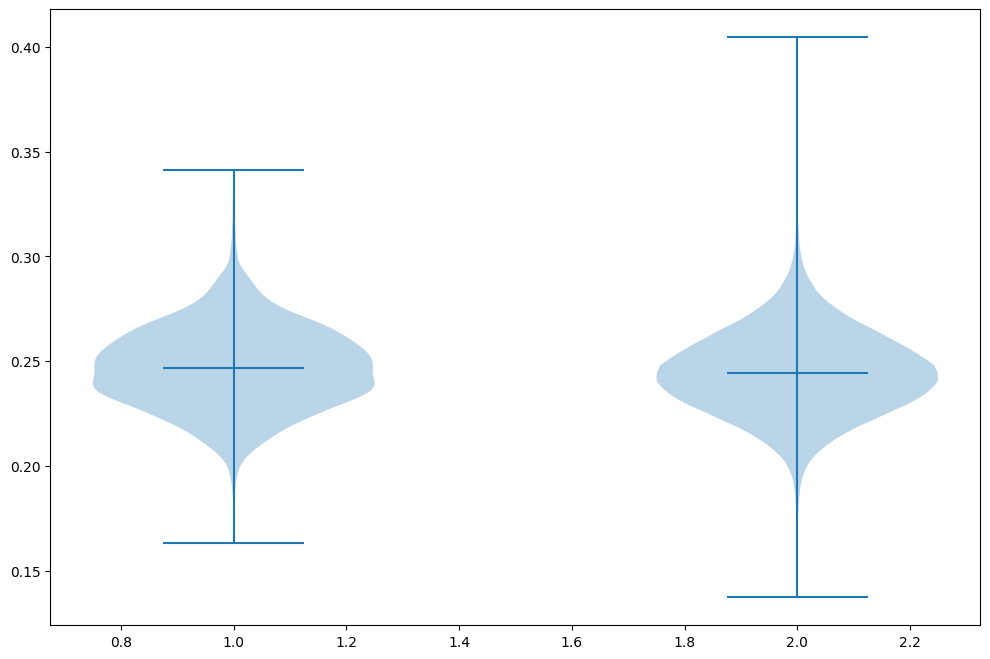

In [564]:
plt.clf()
plt.violinplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

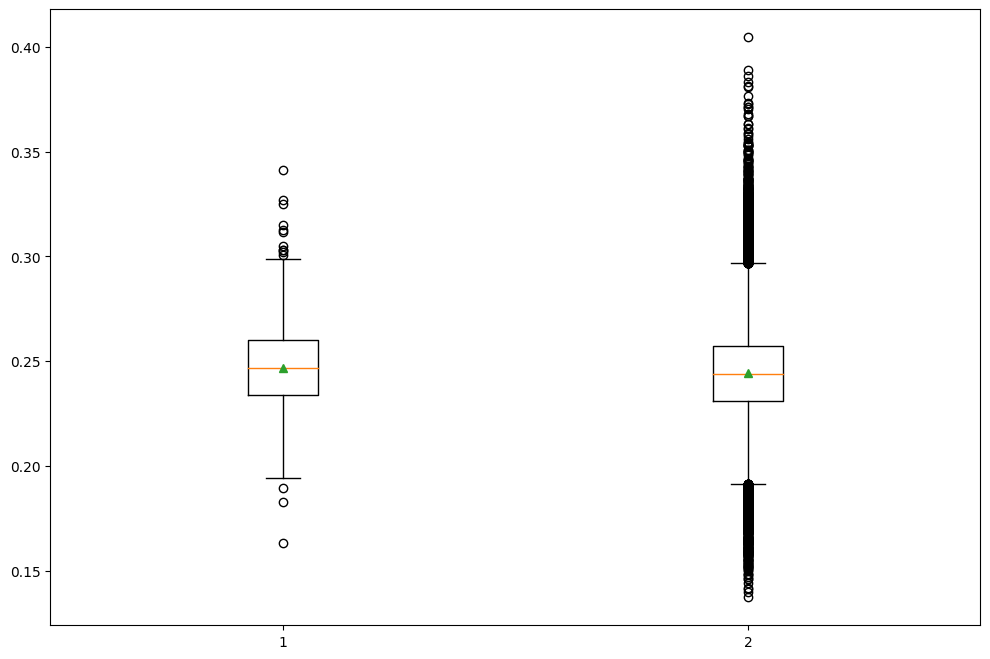

In [565]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

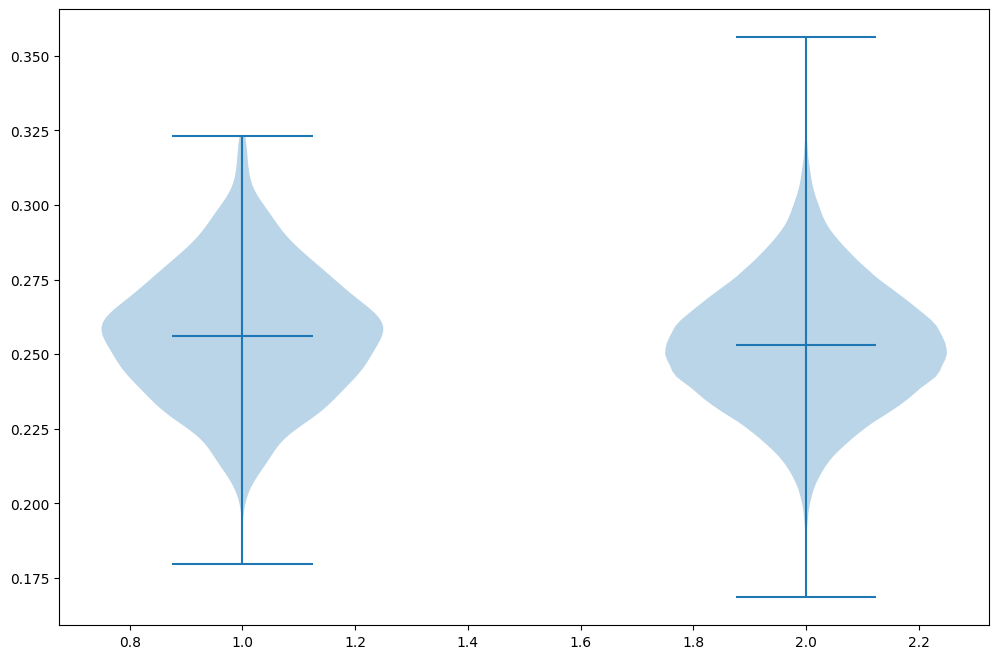

In [566]:
plt.clf()
plt.violinplot(
    [dyad_b2, nyad_b2],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b2, nyad_b2],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
plt.clf()
plt.violinplot(
    [dyad_b3, nyad_b3],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#synchrony values of real and non-real dyads plotted
plt.boxplot(
    [dyad_b3, nyad_b3],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [ ]:
#T-TESTS ARE RAN HERE

In [112]:
from scipy.stats import ttest_ind

In [148]:
#Pre-Play
statistic, pvalue = ttest_ind(
    dyad_b1,
    nyad_b1)

In [149]:
statistic

4.664071638054461

In [150]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 3.1020638409483385e-06


In [151]:
#Puzzle
statistic, pvalue = ttest_ind(
    dyad_b2,
    nyad_b2)

In [152]:
statistic

5.900251188053853

In [153]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 3.6350967172254653e-09


In [154]:
#Post-Play
statistic, pvalue = ttest_ind(
    dyad_b3,
    nyad_b3)

In [155]:
statistic

5.265260793358991

In [156]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 1.4012955922515106e-07


In [ ]:
#Real vs Baseline (zeroes)/One-Sample T-Test 

In [143]:
#find length of block variable first for each real or false synchrony scores
len(nyad_b3)

205879

In [144]:
#Set a list of zeroes for one-sample t-test comparisons
zyad_z1 = []

for num in range(205879):
    zyad_z1.append(0)

In [167]:
#switch the dyad to synchrony block of interest
statistic, pvalue = ttest_ind(
    dyad_b2,
    dyad_b3)

In [168]:
statistic

12.296888982113185

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#2) HERE CAN TEST SPECIFIC ROIs (CHANNELS) BETWEEN REAL vs FALSE DYADS

In [ ]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
  'S3_D2 hbo', # left frontal
  'S4_D2 hbo',
#   'S5_D3 hbo', # right frontal
#   'S6_D3 hbo',
#    'S1_D1 hbo', # left temporal
#    'S2_D1 hbo',
#    'S2_D2 hbo',
#    'S7_D3 hbo', #right temporal
#    'S7_D4 hbo',
#    'S8_D4 hbo'
]

dyad_c1 = [] # make a list for real dyads
nyad_c1 = [] # make a list for not-real dyads

# this is just using Block 1 = Pre-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c1.append(
                sync_df[parent][real_child]['Block 1'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c1.append(
                    sync_df[parent][false_child]['Block 1'][ch])

In [ ]:
#Pre-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c1,
    nyad_c1)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
    'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
#      'S5_D3 hbo', # right frontal
#      'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
#      'S7_D3 hbo', #right temporal
#      'S7_D4 hbo',
#      'S8_D4 hbo'
]

dyad_c2 = [] # make a list for real dyads
nyad_c2 = [] # make a list for not-real dyads

# this is just using Block 2 = Puzzle

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c2.append(
                sync_df[parent][real_child]['Block 2'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c2.append(
                    sync_df[parent][false_child]['Block 2'][ch])

In [ ]:
#Puzzle T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_b2,
    nyad_c2)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#Use these cells below to test specific channels

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
      'S3_D2 hbo', # left frontal
      'S4_D2 hbo',
#       'S5_D3 hbo', # right frontal
#       'S6_D3 hbo',
      'S1_D1 hbo', # left temporal
      'S2_D1 hbo',
      'S2_D2 hbo',
#       'S7_D3 hbo', #right temporal
#       'S7_D4 hbo',
#       'S8_D4 hbo'
]

dyad_c3 = [] # make a list for real dyads
nyad_c3 = [] # make a list for not-real dyads

# this is just using Block 3 = Post-Play

for parent in sync_df.keys():
    
    # REAL DYAD SECTION
    ###################
    real_child = parent.replace("p", "c") # # the real child, AKA true dyad, as a string

    # a loop over all the channels in the dataset
    for ch in channels:
        
        # new February 9th 2023 to ignore bad channels
        good = True # bool flag for whether this channel will get added
        if ch in bad_channels_dict[parent]:
            good = False
        elif ch in bad_channels_dict[real_child]:
            good = False

        if good: # only if the channel wasn't in parent or child's bad_channels_dict
            dyad_c3.append(
                sync_df[parent][real_child]['Block 3'][ch])
        
    # FALSE DYAD SECTION (NYAD)
    ###########################
    false_children = [child for child in sync_df[parent].keys() if child is not real_child] # a list of the false children

    for false_child in false_children:

        # a loop over all the channels in the dataset
        for ch in channels:
        
            # new February 9th 2023 to ignore bad channels
            good = True # bool flag for whether this channel will get added
            if ch in bad_channels_dict[parent]:
                good = False
            elif ch in bad_channels_dict[false_child]:
                good = False

            if good: # only if the channel wasn't in parent or child's bad_channels_dict
                nyad_c3.append(
                    sync_df[parent][false_child]['Block 3'][ch])

In [ ]:
#Post-Play T-test (Real vs False Dyads) - Specific Channels
statistic, pvalue = ttest_ind(
    dyad_c3,
    nyad_c3)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#TESTING BETWEEN BLOCK DIFFERECNES BETWEEN REAL DYADS (AVERAGE ACROSS ALL BLOCKS) THERE SHOULD BE 3 COMBINATIONS TOTAL

In [ ]:
#Use the dyad variables created previously in the Real vs False Dyad analyses to test between Blocks
#T-test (Real vs False Dyads) 
statistic, pvalue = ttest_ind(
    dyad_b1,
    dyad_b3)

In [ ]:
statistic

In [ ]:
print("P Value for Real vs. False Dyads:", pvalue)

In [ ]:
#INCORPORATION of CARE QUESTIONNAIRE SCORES BEGINS HERE

In [ ]:
#The code and CSV for the OLD RDAS files for reference (DON'T RUN THIS SECTION)

In [141]:
# load CSV from emily Hone groups
# groups = pd.read_csv("/data/perlman/moochie/analysis/CARE/forperlman_rdaslist_20221101.csv")
# groups['subject'] = [id.replace('-', '') for id in groups['record_id']]
# groups.set_index('subject', inplace=True)

In [ ]:
groups

In [144]:
# load CSV from emily Hone's RDAS scores
# scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/Clayton_Alana/forkhalil_fullscored.csv")
# scores['subject'] = [id.replace('-', '') for id in scores['record_id']]
# scores.set_index('subject', inplace=True)
# scores.drop(columns=['record_id'], inplace=True)
# scores = scores.astype({'famid': 'str'})

In [ ]:
scores

In [146]:
# see how many rows there are in there
# weird number, huh?
# it's because not everybody has RDAS data :(
# len([id for id in scores.index])

112

In [539]:
#START HERE (Incorporates most recent baseline data from Pitt Group)

In [95]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'rdas_consensus',
    'rdas_satisfaction',
    'rdas_cohesion',
    'rdas_total'
#     'total'
]

channels = [
     'S3_D2 hbo', # left frontal
     'S4_D2 hbo',
     'S5_D3 hbo', # right frontal
     'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
     'S7_D3 hbo', # right temporal
     'S7_D4 hbo',
     'S8_D4 hbo',
]

In [96]:
channels

['S3_D2 hbo',
 'S4_D2 hbo',
 'S5_D3 hbo',
 'S6_D3 hbo',
 'S1_D1 hbo',
 'S2_D1 hbo',
 'S2_D2 hbo',
 'S7_D3 hbo',
 'S7_D4 hbo',
 'S8_D4 hbo']

In [97]:
COIs

['rdas_consensus', 'rdas_satisfaction', 'rdas_cohesion', 'rdas_total']

In [98]:
# load CARE Pitt Group CSV 
scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/Baseline_PSU_csv.csv")
scores['subject'] = [id for id in scores['record_id']]
scores = scores.astype({'subject': 'str'})
scores = scores.mask(scores == ' ')
for COI in COIs:
    scores = scores.astype({COI: 'float'})
scores.set_index('subject', inplace=True)
scores.drop(columns=['record_id'], inplace=True)

In [99]:
#PRQ = Parent Relationship Questionnaire
scores

,family_id,group,timepoint,date,age,sex_at_birth,sex_male,race,race_white,ethnicity,...,rdas_c_11_current,rdas_c_12_current,rdas_c_13_current,rdas_c_14_current,revised_dyadic_adjustment_scale_rdas_complete,revised_dyadic_adjustment_scale_rdas_divorce_complete,rdas_consensus,rdas_satisfaction,rdas_cohesion,rdas_total
subject,,,,,,,,,,,,,,,,,,,,,
50001,5000,divorce,0,2021-01-11,5.286790,male,True,white,True,Not Hispanic or Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50021,5002,control,0,2021-03-18,5.130732,female,False,white,True,Not Hispanic or Latino,...,3.0,4.0,3.0,4.0,2.0,NaN,27.0,17.0,13.0,57.0
50031,5003,control,0,2021-07-06,4.002738,female,False,white,True,Not Hispanic or Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50032,5003,control,0,2021-07-29,7.945243,male,True,white,True,Not Hispanic or Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50071,5007,control,0,2021-03-31,5.032170,male,True,multiracial,False,Not Hispanic or Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51801,5180,control,0,2023-03-22,7.134839,male,True,Asian,False,Not Hispanic or Latino,...,1.0,3.0,0.0,0.0,2.0,NaN,24.0,16.0,6.0,46.0
51831,5183,control,0,2023-03-28,6.841889,male,True,multiracial,False,Not Hispanic or Latino,...,2.0,3.0,3.0,3.0,2.0,NaN,24.0,15.0,11.0,50.0
51841,5184,control,0,2023-03-28,5.845311,female,False,white,True,Not Hispanic or Latino,...,2.0,3.0,2.0,3.0,2.0,NaN,22.0,15.0,8.0,45.0


In [100]:
scores.columns

Index(['family_id', 'group', 'timepoint', 'date', 'age', 'sex_at_birth',
       'sex_male', 'race', 'race_white', 'ethnicity',
       ...
       'rdas_c_11_current', 'rdas_c_12_current', 'rdas_c_13_current',
       'rdas_c_14_current', 'revised_dyadic_adjustment_scale_rdas_complete',
       'revised_dyadic_adjustment_scale_rdas_divorce_complete',
       'rdas_consensus', 'rdas_satisfaction', 'rdas_cohesion', 'rdas_total'],
      dtype='object', length=1119)

In [101]:
scores.index

Index(['50001', '50021', '50031', '50032', '50071', '50081', '50091', '50092',
       '50101', '50111',
       ...
       '51741', '51751', '51771', '51781', '51791', '51801', '51831', '51841',
       '51851', '51881'],
      dtype='object', name='subject', length=174)

In [102]:
# see how many rows there are in there
len([id for id in scores.index])

174

In [103]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

Coefficient of Determination: 0.004544674028192142
intercept: 0.24216204947384173
slope: [0.00015168]


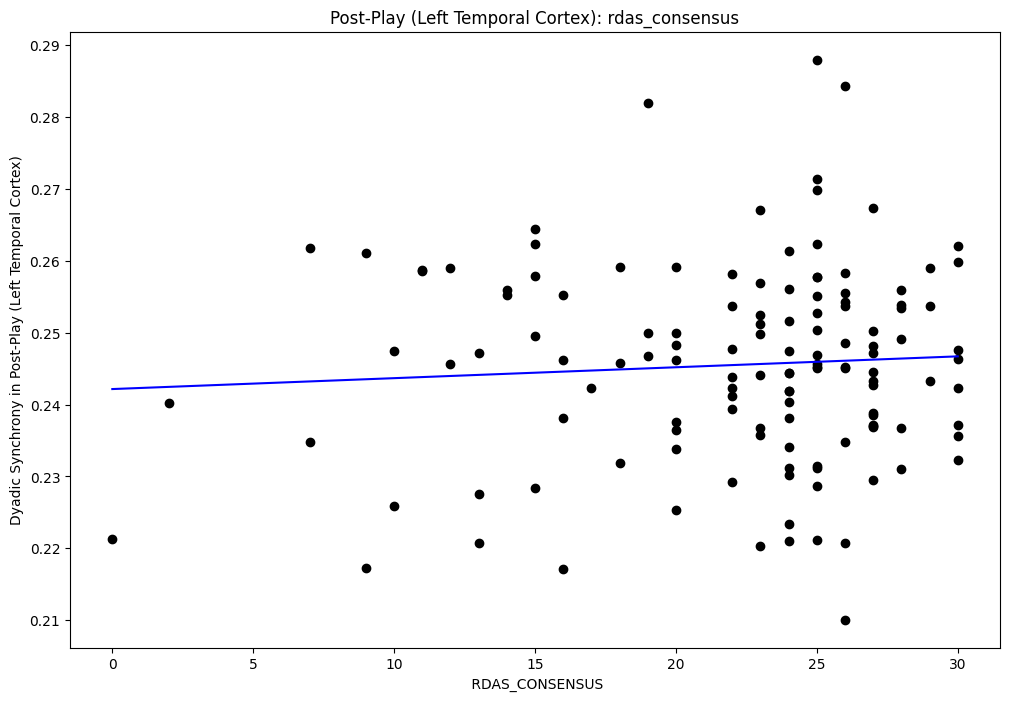

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5889
Date:                Thu, 06 Jul 2023   Prob (F-statistic):              0.444
Time:                        12:35:57   Log-Likelihood:                 376.00
No. Observations:                 131   AIC:                            -748.0
Df Residuals:                     129   BIC:                            -742.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2422      0.005     53.456      0.0

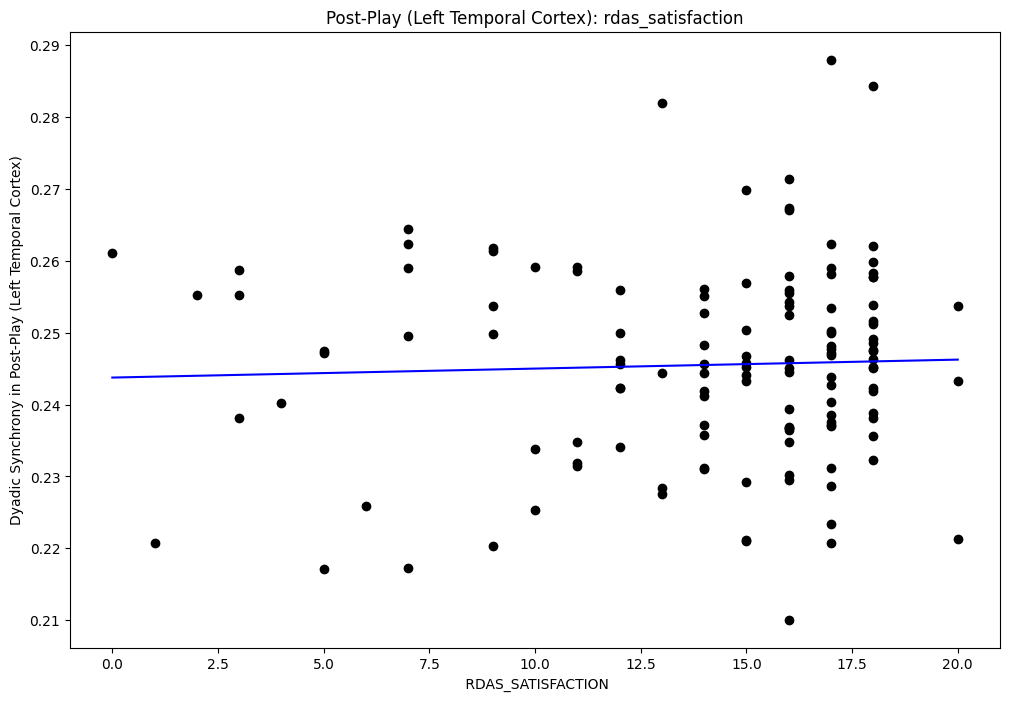

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2055
Date:                Thu, 06 Jul 2023   Prob (F-statistic):              0.651
Time:                        12:35:58   Log-Likelihood:                 375.81
No. Observations:                 131   AIC:                            -747.6
Df Residuals:                     129   BIC:                            -741.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2438      0.004     60.241      0.0

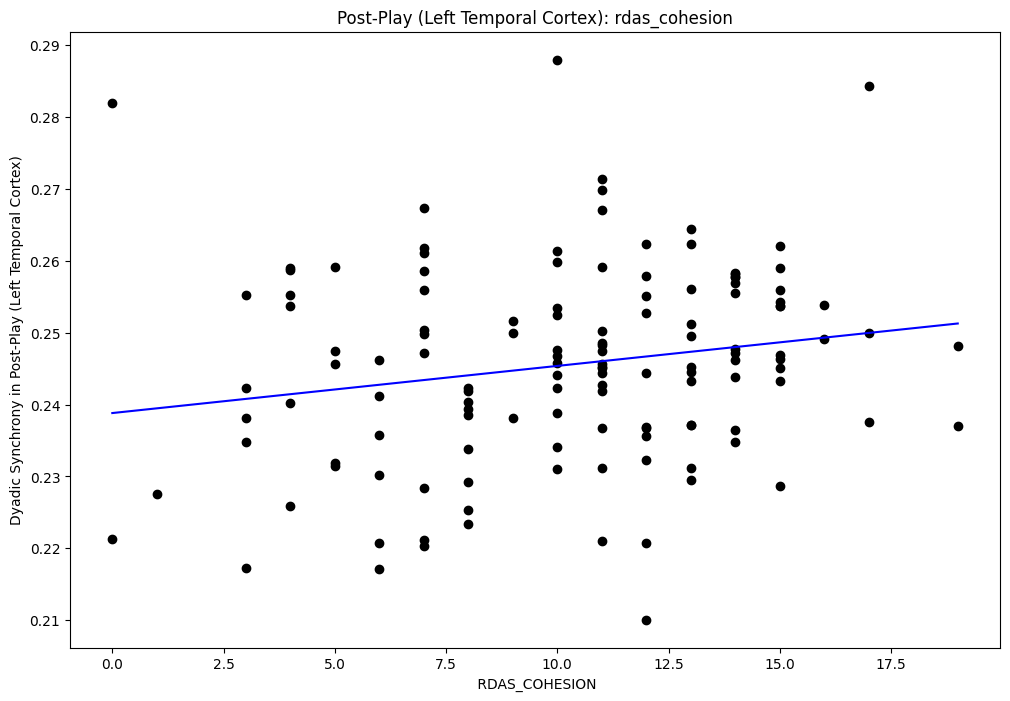

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4.917
Date:                Thu, 06 Jul 2023   Prob (F-statistic):             0.0283
Time:                        12:35:58   Log-Likelihood:                 378.15
No. Observations:                 131   AIC:                            -752.3
Df Residuals:                     129   BIC:                            -746.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2388      0.003     73.660      0.0

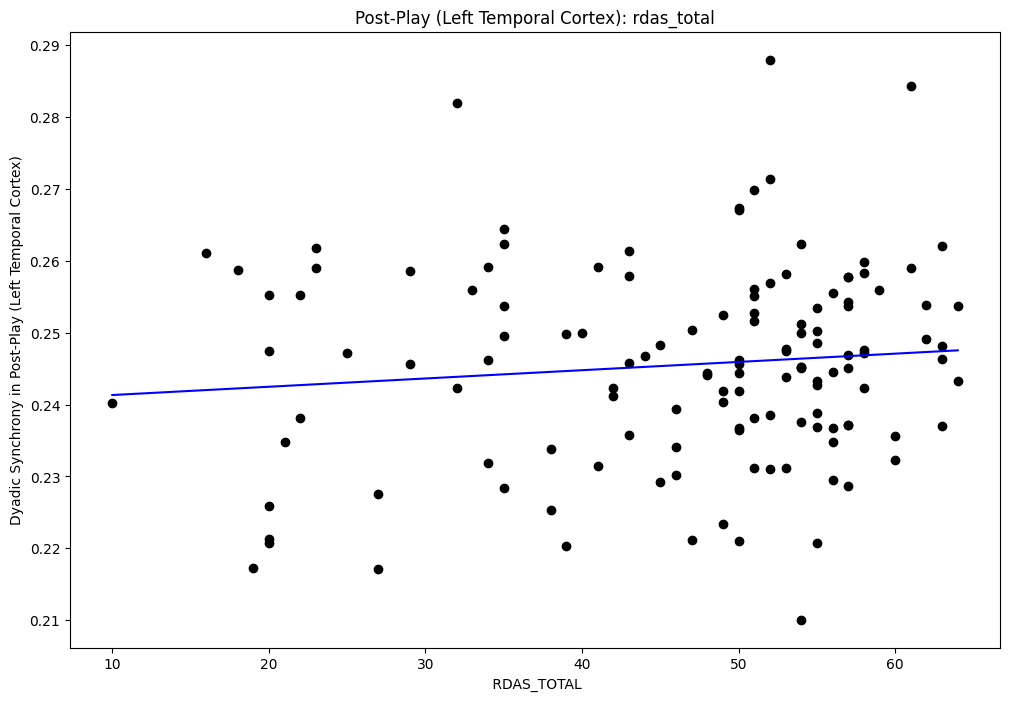

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.482
Date:                Thu, 06 Jul 2023   Prob (F-statistic):              0.226
Time:                        12:35:58   Log-Likelihood:                 376.45
No. Observations:                 131   AIC:                            -748.9
Df Residuals:                     129   BIC:                            -743.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2402      0.005     52.886      0.0

In [104]:
# this is because, in the sync_df, we need to have a way to differentiate between the parent and child. so subject names are, e.g.
# 1234p or 1234c. Whereas, in your .csv / dataframe for other variables of interest, they are not specific to a parent or child, but a family. 
# so we often combine these values by looping over the parents (top level values in sync_df that end in "p"), and then reference that name,
# with the "p" replaced by "" (nothing) to access the correct value in the dataframe. 

channels = [
     'S3_D2 hbo', # left frontal
     'S4_D2 hbo',
     'S5_D3 hbo', # right frontal
     'S6_D3 hbo',
     'S1_D1 hbo', # left temporal
     'S2_D1 hbo',
     'S2_D2 hbo',
     'S7_D3 hbo', # right temporal
     'S7_D4 hbo',
     'S8_D4 hbo'
]

#Set the Block of Interest here

block_num = 'Block 1'
block_name = 'Pre-Play'

# Set an identifier function for handling family id
# Use the difference in size of the ID's as a guide
sync_sample = list(sync_df.keys())[0]
scores_sample = scores.index[0]
identifier_diff =  len(scores_sample) - len(sync_sample) # Figure out how much smaller the scores sample is
score_identifier = lambda string : string[:identifier_diff]

# Variant 1 (individual block)
# ==================
# for all the parent / child pairs who are listed in the scores .csv / dataframe,
#    and averaging over all the channels that are uncommented above
#    so this will yield a list called "syncs" which is as long as the number of parent / child pairs 
#    that are found in both sync_df and the scores dataframe
#    i.e. 1 averaged WTC value per dyad, specifically derived from whichever block is named in 
#    "block_num" above.

syncs = []
sync_parents = []
for parent in list(sync_df.keys()):
    dyad_syncs = []
    child = parent.replace('p', 'c')
    if score_identifier(parent) in list(scores.index):
        for ch in channels:
            if ch not in bad_channels_dict[parent]:
                if ch not in bad_channels_dict[child]:
                    dyad_syncs.append(sync_df[parent][child][block_num][ch])
    if len(dyad_syncs) > 0:
        syncs.append(np.average(dyad_syncs))
        sync_parents.append(parent)
        
# print(sync_parents)
# Variant 2 (block difference)
# ==================
# this version is doing the same thing, but specifically looking at the _difference_ of the WTC
#    in a dyad between two blocks. In this example, you can see that it is marking the difference
#    between sync of 'Block 2' and 'Block 1'. You are welcome to configure those variables 
#    as you see fit. The shape of the output list, syncs, will be the same as in Variant 1, and you
#    could use it just as well in any subsequent regressions, etc.  


# syncs = []
# sync_parents = []
# for parent in list(sync_df.keys()):
#    dyad_syncs = []
#    child = parent.replace('p', 'c')
#    if parent.replace('p', '') in list(scores.index):
#       for ch in channels:
#          if ch not in bad_channels_dict[parent]:
#             if ch not in bad_channels_dict[child]:
#                dyad_syncs.append(
#                   sync_df[parent][child]['Block 1'][ch] - \
#                   sync_df[parent][child]['Block 3'][ch])
#    if len(dyad_syncs) > 0:
#       syncs.append(np.average(dyad_syncs))
#       sync_parents.append(parent)


# Regression
# ================
# looping over the "columns of interest" which should be defined in a previous cell. as COIs = [ <stuff> ]
#     i.e., the names of any columns in your .csv you want to run regression on
for COI in COIs:

    # get the current variable of interest from the "scores" dataframe
    #    once again, only for subjects who are found in both the sync_df 
    #    and in the scores dataframe / .csv.
    voi = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_parents]]
    
    # force the values read to be interpreted as float, as opposed to default string
    xnan = np.array(voi, dtype='float')
    ynan = np.array(syncs, dtype='float')

    # IQR correction if desired
#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)
#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    # remove any values that are NaN (hopefully none?) otherwise there
    #    may be issues in your .csv format 
    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))

    # Winsorize function (not recommended)
    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    # duplicate variables for use in regression (requires reshaping)
    X = x
    Y = y
    x = x.reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    # plot data
    plt.clf()
    plt.scatter(
        x,
        y,
        color='black')

    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)

    plt.xlabel(f" {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")
    plt.show()
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())

In [ ]:
len(set([sub[:-1] for sub in list(sync_df.keys())]))

In [ ]:
#Older code to run group analysis for RDAS data (CAN STOP HERE UNLESS YOU NEED TO RUN GROUPS)

In [ ]:
# Differences in synchrony between the conflict and non-conflict group
group1syncs = [] # get synchrony from all of groups 1 (control)
group2syncs = [] # get synchrony from problem group

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

for sub in sync_df.keys():
    avgsync = np.average([
        sync_df[sub][sub.replace('p', 'c')]['Block 2'][ch] for ch in channels])
    
    if (groups.loc[[sub.replace('p', '')]]['enroll_group'][0] == "Control") and \
        (groups.loc[[sub.replace('p', '')]]['rdas_group'][0] == "Non-Conflict"):
        group1syncs.append(avgsync)
    else:
        group2syncs.append(avgsync)
        
plt.clf()
plt.violinplot(
    [group1syncs, group2syncs],
    showmeans=True)
plt.show()

statistic, pvalue = ttest_ind(
    group1syncs,
    group2syncs)

print("T stat:", statistic, "\n", "P value:", pvalue)

In [ ]:
np.std(group2syncs)

In [ ]:
# enrollment group 2 OR above RDAS critical value == conflict group

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [ ]:
#configuration section that allows you to change which blocks, RDAS columns, and channels you want to include in subsequent analysis
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'consensus',
    'satisfaction',
    'cohesion',
#     'total'
]

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]